# Lotka-Volterra

Let's find the fastest solver of the Lotka--Volterra problem, a standard benchmark problem. It is low-dimensional, not stiff, and generally poses no major problems for any numerical solver.

In [1]:
from functools import partial

import jax
import jax.experimental.ode
import jax.numpy as jnp
import matplotlib.pyplot as plt
from _benchmark_utils import most_recent_commit, plot_config, time
from diffeqzoo import backend, ivps
from jax import config
from tqdm import tqdm

from odefilter import controls, ivpsolve, recipes

# Nice-looking plots
plt.rcParams.update(plot_config())

# x64 precision
config.update("jax_enable_x64", True)

# IVP examples in JAX, not in NumPy
backend.select("jax")

In [2]:
from odefilter import __version__ as odefilter_version  # noqa: E402

commit = most_recent_commit(abbrev=6)


print(f"Most recent commit:\n\t{commit}")
print(f"odefilter version:\n\t{odefilter_version}")
print()
jax.print_environment_info()

Most recent commit:
	b'99b43f\n'
odefilter version:
	0.0.1a1

jax:    0.3.23
jaxlib: 0.3.22
numpy:  1.23.3
python: 3.8.10 (default, Jun 22 2022, 20:18:18)  [GCC 9.4.0]
jax.devices (1 total, 1 local): [CpuDevice(id=0)]
process_count: 1


This is the problem:

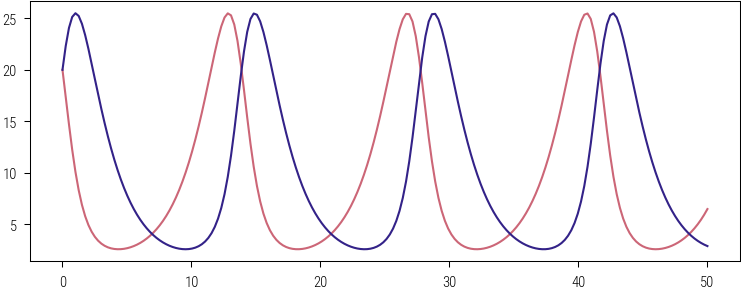

In [3]:
# Make a problem
f, u0, (t0, t1), f_args = ivps.lotka_volterra(time_span=(0.0, 50.0))
ODE_NAME = "Lotka-Volterra"


@jax.jit
def vf(x, *, t, p):
    return f(x, *p)


# Compile
vf(u0, t=t0, p=f_args)

ts = jnp.linspace(t0, t1, num=200)
odeint_solution = jax.experimental.ode.odeint(
    lambda u, t, *p: vf(u, t=t, p=p), u0, ts, *f_args, atol=1e-12, rtol=1e-12
)
ys_reference = odeint_solution[-1, :]

fig, ax = plt.subplots(figsize=(5, 2))
ax.plot(ts, odeint_solution, marker="None")
plt.show()

## Internal solvers
Let's start with finding the fastest ODE filter.

### Terminal-value simulation

In [8]:
def prepare(solver, **kwargs):
    return jax.jit(partial(_solve, solver=solver))


def _solve(*, solver, tol):
    solution = ivpsolve.simulate_terminal_values(
        vf,
        initial_values=(u0,),
        t0=t0,
        t1=t1,
        parameters=f_args,
        solver=solver,
        atol=1e-3 * tol,
        rtol=tol,
        control=controls.ClippedProportionalIntegral(),
    )
    diff = (solution.u - ys_reference) / (1e-5 + ys_reference)
    return jnp.linalg.norm(diff) / jnp.sqrt(diff.size)

In [9]:
def workprecision(*, solve_fns, tols, **kwargs):
    results = {}
    for solve_fn, label in tqdm(solve_fns):

        times, errors = [], []

        for rtol in tols:

            def bench():
                return solve_fn(tol=rtol)

            t, error = time(bench, **kwargs)

            times.append(t)
            errors.append(error)

        results[label] = (times, errors)
    return results

In [10]:
d = u0.shape[0]

ekf1_3 = prepare(recipes.ekf1(num_derivatives=3, ode_dimension=d))
ckf1_3 = prepare(recipes.ckf1(num_derivatives=3, ode_dimension=d))
ekf1_3_dynamic = prepare(
    recipes.ekf1(calibration="dynamic", num_derivatives=3, ode_dimension=d)
)
ekf1_4 = prepare(recipes.ekf1(num_derivatives=4, ode_dimension=d))
ckf1_4 = prepare(recipes.ckf1(num_derivatives=4, ode_dimension=d))
ekf1_5_dynamic = prepare(
    recipes.ekf1(calibration="dynamic", num_derivatives=5, ode_dimension=d)
)
eks1_5_dynamic = prepare(
    recipes.eks1(calibration="dynamic", num_derivatives=5, ode_dimension=d)
)
ekf1_7 = prepare(recipes.ekf1(num_derivatives=7, ode_dimension=d))
ckf1_7 = prepare(recipes.ckf1(num_derivatives=7, ode_dimension=d))
ekf1_7_dynamic = prepare(
    recipes.ekf1(calibration="dynamic", num_derivatives=7, ode_dimension=d)
)
ekf0_3_isotropic = prepare(recipes.ekf0_isotropic(num_derivatives=3))
ekf0_3_isotropic_dynamic = prepare(
    recipes.ekf0_isotropic(calibration="dynamic", num_derivatives=3)
)
ekf0_5_isotropic = prepare(recipes.ekf0_isotropic(num_derivatives=5))
eks0_5_isotropic_dynamic = prepare(
    recipes.eks0_isotropic(calibration="dynamic", num_derivatives=5)
)
ekf0_5_isotropic_dynamic_fixpt = prepare(
    recipes.eks0_isotropic_fixedpoint(calibration="dynamic", num_derivatives=5)
)

solve_fns = [
    # EK1
    #     (ekf1_3, f"EKF1({3})"),
    #     (ckf1_3, f"CKF1({3})"),
    # (ekf1_3_dynamic, f"Dynamic EKF1({3})"),
    (ekf1_4, f"EKF1({4})"),
    (ckf1_4, f"CKF1({4})"),
    #     (ekf1_5_dynamic, f"Dynamic EKF1({5})"),
    #     (eks1_5_dynamic, f"Dynamic EKS1({5})"),
    #     (ekf1_7, f"EKF1({7})"),
    # (ckf1_7, f"CKF1({7})"),
    # # EK0
    #     (ekf0_3_isotropic, f"Isotropic EKF0({3})"),
    #     (ekf0_3_isotropic_dynamic, f"Dynamic Isotropic EKF0({3})"),
    #     (ekf0_5_isotropic, f"Isotropic EKF0({5})"),
    #     (eks0_5_isotropic_dynamic, f"Dynamic Isotropic EKS0({5})"),
    #     (ekf0_5_isotropic_dynamic_fixpt, f"Dynamic Isotropic FixPt-EKS0({5})"),
]

In [11]:
%%time

tolerances = 0.1 ** jnp.arange(1.0, 11.0, step=0.5)

results = workprecision(solve_fns=solve_fns, tols=tolerances, number=3, repeat=3)

100%|█████████████████████████████████████████████| 2/2 [00:08<00:00,  4.17s/it]

CPU times: user 8.51 s, sys: 34.1 ms, total: 8.54 s
Wall time: 8.36 s


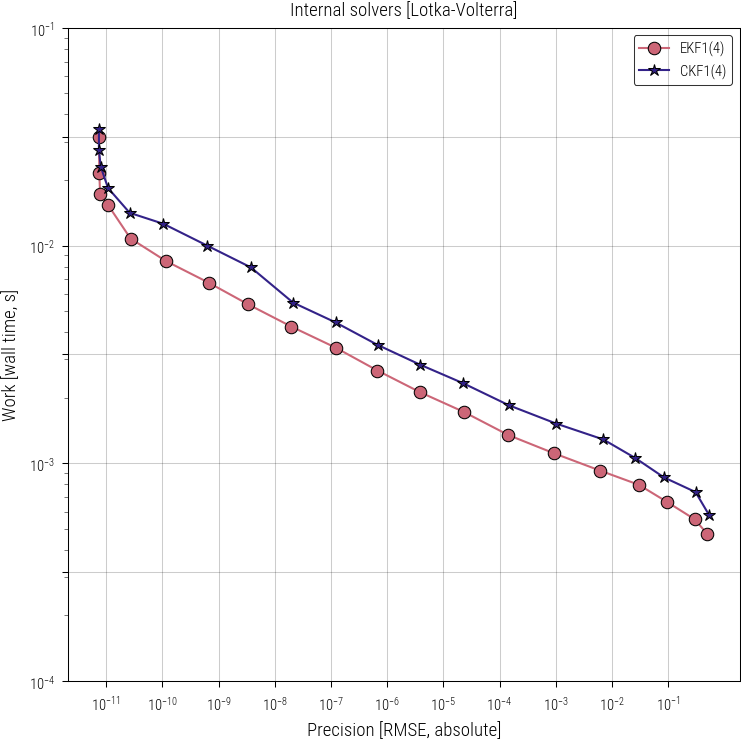

In [12]:
fig, ax = plt.subplots(figsize=(5, 5))

for solver in results:
    times, errors = results[solver]
    ax.loglog(errors, times, label=solver)

ax.grid("both")
ax.set_xticks(0.1 ** (jnp.arange(1.0, 12.0, step=1.0)))
ax.set_yticks(0.1 ** (jnp.arange(1.0, 4.5, step=0.5)))
ax.set_title(f"Internal solvers [{ODE_NAME}]")
ax.set_xlabel("Precision [RMSE, absolute]")
ax.set_ylabel("Work [wall time, s]")
ax.legend()
plt.show()

If these results show one thing, then the fact that it is worth building a specialised ODE solver
for simulate_terminal_values(). The smoothing-based solvers compute extra factors that are just not needed for terminal-value simulation, and the extra factors turn out to be quite expensive. Every smoother was slower than its filtering-equivalent.

We can observe more:
* Dynamic calibration seems to perform at most as good as non-dynamic calibration. (Except for low order, low-precision EKF1, where the dynamic calibration seems to help. But even with the dynamic calibration is the low-order EKF1 one of the slowest solvers.)
* Low precision is best achieved with an isotropic EKF0(3). High precision is best achieved with an EKF1(8). The middle ground is better covered by an isotropic EKF0(5) than an EKF1(5).
* The cubature filters are more expensive than the extended filters (because cubature-linearisation costs more than Taylor-linearisation)


## External solvers
TBD.